In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import norm
import scipy.integrate as integrate
import timeit
from operator import mul
from functools import reduce

In [2]:
np.random.seed(2)

In [20]:
## Set parameters

# data parameters
size = 100
mean_mu = 0
sigma_mu = 1
sigma_x = 1

# model parameters
prior_mean_mu = 0
prior_sigma_mu = 1
prior_sigma_x = 1

# plot parameters
resolution_joint_mu = 200
resolution_joint_x = 200
range_joint_mu_upper = 3
range_joint_mu_lower = -3
range_joint_x_upper = 3
range_joint_x_lower = -3
resolution_marginal_mu = 100
resolution_marginal_x = 100
range_marginal_mu_upper = 4
range_marginal_mu_lower = -4
range_marginal_x_upper = 4
range_marginal_x_lower = -4

In [21]:
## Generate data
mu = np.random.normal(mean_mu,sigma_mu,size=size)
X = np.random.normal(mu,sigma_x)

In [22]:
## Calculate joint posterior distribution
def prior_mu(mu):
    density = norm.pdf(mu, loc=prior_mean_mu, scale=prior_sigma_mu)
    return density

def likelihood_x(x,mu):
    density = norm.pdf(x, loc=mu, scale=prior_sigma_x)
    return density

def likelihood_X(X,mu): 
    likelihoods = [likelihood_x(point,mu) for point in X]
    res = reduce(mul, likelihoods, 1)
    return res

#def likelihood_times_prior_mu(X,mu):
#    return likelihood_X(X,mu) * prior_mu(mu)

#def prior_X(X):
#    res = integrate.quad(lambda mu: likelihood_times_prior_mu(X,mu),a=-np.inf,b=np.inf)[0]
#    return res

#def joint_posterior(x,mu,X):
#    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
#    return res

def joint_posterior_without_normalizing_constant(x,mu,X):
    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu)
    return res

def posterior_marginal_x_without_normalizing_constant(x,X):
    res = integrate.quad(lambda mu:joint_posterior_without_normalizing_constant(mu=mu,X=X,x=x),a=-np.inf,b=np.inf)[0]
    return res

#def posterior_marginal_mu(mu,X):
#    res = likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
#return res

def posterior_marginal_mu_without_normalizing_constant(mu,X):
    res = likelihood_X(X,mu) * prior_mu(mu) 
    return res

In [23]:
## Improve performance of calculations

def prior_mu_vectorized(mu_vector):
    res = [prior_mu(mu) for mu in mu_vector]
    return res

def likelihood_X_vectorized(X,mu_vector):
    res = [likelihood_X(X,mu) for mu in mu_vector]
    return res

def likelihood_x_vectorized(x_vector,mu_vector):
    res = [likelihood_x(x,mu) for x in x_vector for mu in mu_vector]
    res = np.reshape(np.asarray(res),(resolution_joint_x,resolution_joint_mu))
    return res

def joint_posterior_without_normalizing_constant_vectorized(x_vector,mu_vector,X):
    res = np.multiply(prior_mu_vectorized(mu_vector),likelihood_X_vectorized(X,mu_vector))
    res = np.multiply(likelihood_x_vectorized(x_vector,mu_vector),res)
    return res

In [24]:
## Build grid for plotting joint posterior distribution

mu_plot = linspace(range_joint_mu_lower,range_joint_mu_upper,resolution_joint_mu)
x_plot = linspace(range_joint_x_lower,range_joint_x_upper,resolution_joint_x)

grid = joint_posterior_without_normalizing_constant_vectorized(x_plot,mu_plot,X)

In [27]:
## Calculate marginals for visualization
marginals_x = [posterior_marginal_x_without_normalizing_constant(x,X) for x in np.linspace(-4,4,resolution_marginal_x)]
marginals_mu = [posterior_marginal_mu_without_normalizing_constant(mu,X) for mu in np.linspace(-4,4,resolution_marginal_mu)]

Time marginals_x:  53.262793756000065
Time marginals_mu:  0.5817267799998262


Text(0.5, 1.0, 'Joint Posterior Distribution (not normalized)')

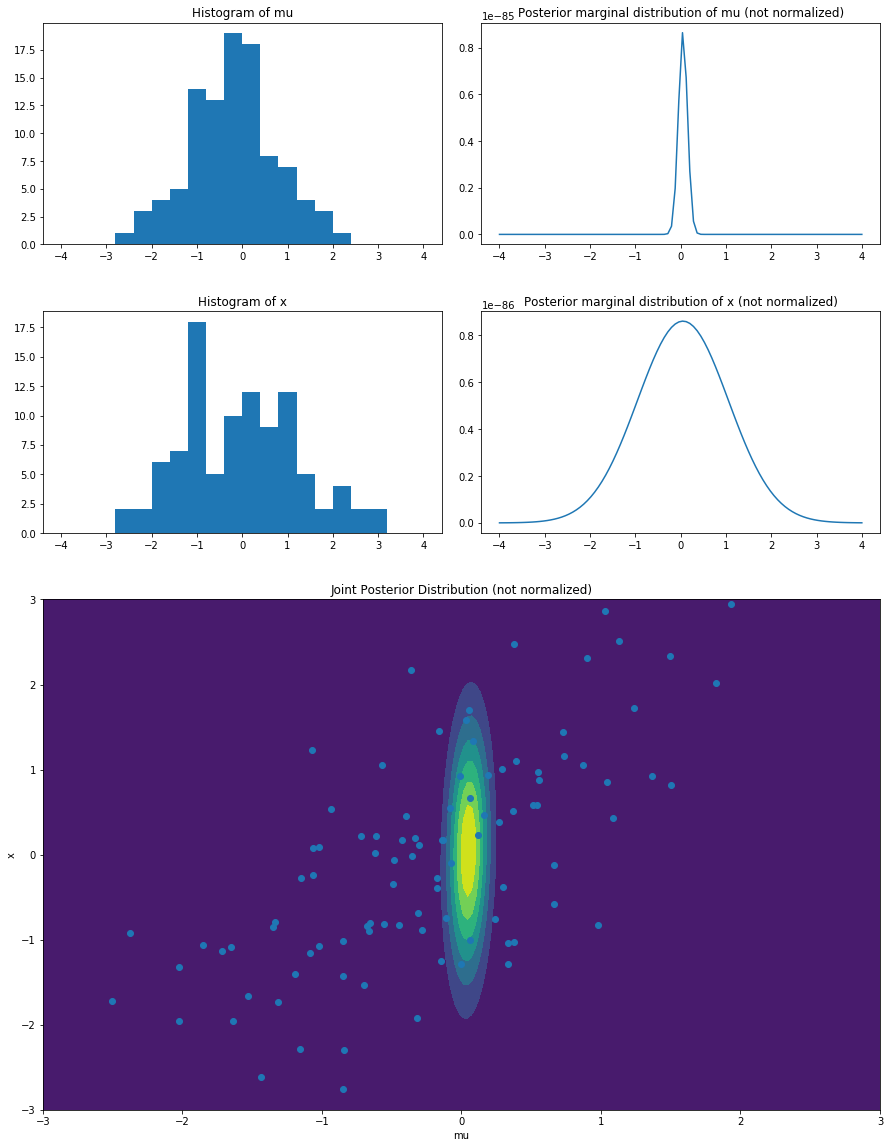

In [26]:
## Plot posterior distributions

plt.figure(figsize=(15,20))
vis_grid = plt.GridSpec(4, 2, wspace=0.1, hspace=0.3)

plt.subplot(vis_grid[0, 0])
hist(mu,range=[range_marginal_mu_lower,range_marginal_mu_upper],bins=20)
plt.title('Histogram of mu')

plt.subplot(vis_grid[0, 1:])
plt.plot(np.linspace(range_marginal_mu_lower,range_marginal_mu_upper,resolution_marginal_mu), marginals_mu)
plt.title('Posterior marginal distribution of mu (not normalized)')
plt.subplot(vis_grid[1, :])

plt.subplot(vis_grid[1, 0])
hist(X,range=[range_marginal_x_lower,range_marginal_x_upper],bins=20)
plt.title('Histogram of x')

plt.subplot(vis_grid[1, 1:])
plt.plot(np.linspace(range_marginal_x_lower,range_marginal_x_upper,resolution_marginal_x), marginals_x)
plt.title('Posterior marginal distribution of x (not normalized)')

plt.subplot(vis_grid[2:4, :])
cnt = contourf(mu_plot, x_plot, grid)
plt.xlabel('mu')
plt.ylabel('x')
plt.ylim((-3,3))
plt.xlim((-3,3))
_ = plt.scatter(mu, X)
plt.title('Joint Posterior Distribution (not normalized)')